In [1]:
%matplotlib notebook
%matplotlib inline

In [2]:
# importing necessary libraries for the 'Water Allocation Price Prediction' model development project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout

In [3]:
# reading the water market transactions data for Goulburn
data_Murray_Goulburn_Murray = pd.read_csv('data_Murray_Goulburn_Murray.csv')

In [4]:
# displaying the data
data_Murray_Goulburn_Murray 

,Total Traded Volume (ML),Volume Weighted Average Price ($),Date
0,120.0,2610.816667,2009-05-01
1,2806.6,672.739543,2009-06-01
2,18812.9,2227.445579,2009-07-01
3,1290.2,2265.075947,2009-08-01
4,240.3,2318.435289,2009-09-01
...,...,...,...
175,595.0,4699.613445,2023-12-01
176,577.5,5918.474405,2024-01-01
177,1080.6,1951.919304,2024-02-01
178,714.4,4044.883819,2024-03-01


In [5]:
# extracting the column of 'Volume Weighted Average Price ($)' from the data
price_data = data_Murray_Goulburn_Murray ['Volume Weighted Average Price ($)']

In [6]:
# this function reforms the data as relevant for time series estimation

def data_to_X_y(data, window_size):
    
    data = data.to_numpy()
    X = []
    y = []
    
    for i in range(len(data) - window_size):
        
        row = [[a] for a in data[i:i + window_size]]
        X.append(row)
        
        actual_value = data[i + window_size]
        y.append(actual_value)
    
    return np.array(X), np.array(y)

In [7]:
# choosing a window size and creating appropriate datasets for time series estimation

window_size = 3

X, y = data_to_X_y(price_data, window_size)

# displaying shapes of reformed datasets
X.shape, y.shape

((177, 3, 1), (177,))

In [8]:
# generating training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True)

# displaying shapes of training and test datasets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((123, 3, 1), (123,), (54, 3, 1), (54,))

In [9]:
# creating an input layer for a deep neural network in an attempt to capture non-linear relationship between the variables of interest
input_layer = Input(shape = (X_train.shape[1], X_train.shape[2]))

# creating two Dense layers to capture non-linear relationship between the varibales of interest for effective prediction
hidden_1 = LSTM(128, activation = 'relu')(input_layer)
dropout_1 = Dropout(0.2)(hidden_1)
hidden_2 = Dense(64, activation = 'relu')(dropout_1)
dropout_2 = Dropout(0.2)(hidden_2)

# creating an output layer with a single unit and the 'linear' activation function since a regression problem is under consideration
output_layer = Dense(1, activation = 'linear')(dropout_2)

# creating a model of the above structure for a deep neural network 
model = tf.keras.Model(inputs = input_layer, outputs = output_layer)

In [10]:
# displaying the model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 74,881
Trainable params: 74,881
Non-trainable params: 0
_________________________________________________________

In [11]:
# choosing an optimizer, loss function and a performance metric to comppile the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              loss = tf.keras.losses.MeanSquaredError(), 
              metrics = tf.keras.metrics.MeanSquaredError())

In [12]:
# an initial selection of epochs and batch size
epochs = 300
batch_size = 1

# training the model and recording its training history for further performance analysis
model_training = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose = 0)

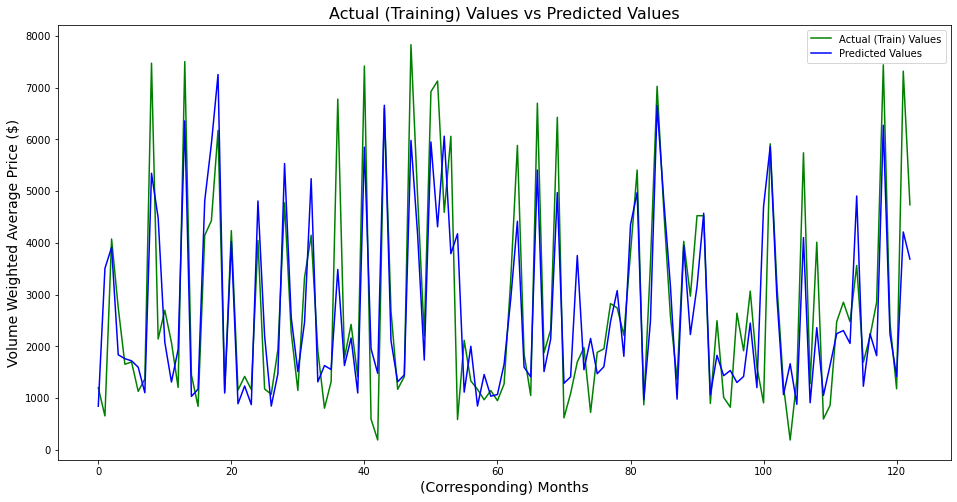

In [13]:
# making predictions using the training dataset to evaluate the training performance of the model
train_predictions = model.predict(X_train)

# creating a figure for the comparison of actual and predicted values
plt.figure(figsize = (16, 8))

# plotting actual training values and predicted values
plt.plot(y_train, color = 'green', label = 'Actual (Train) Values')
plt.plot(train_predictions, color = 'blue', label = 'Predicted Values')

# labeling and naming the figure
plt.xlabel('(Corresponding) Months', fontsize = 14)
plt.ylabel('Volume Weighted Average Price ($)', fontsize = 14)
plt.title('Actual (Training) Values vs Predicted Values', fontsize = 16)

# putting a legend into the figure
plt.legend()

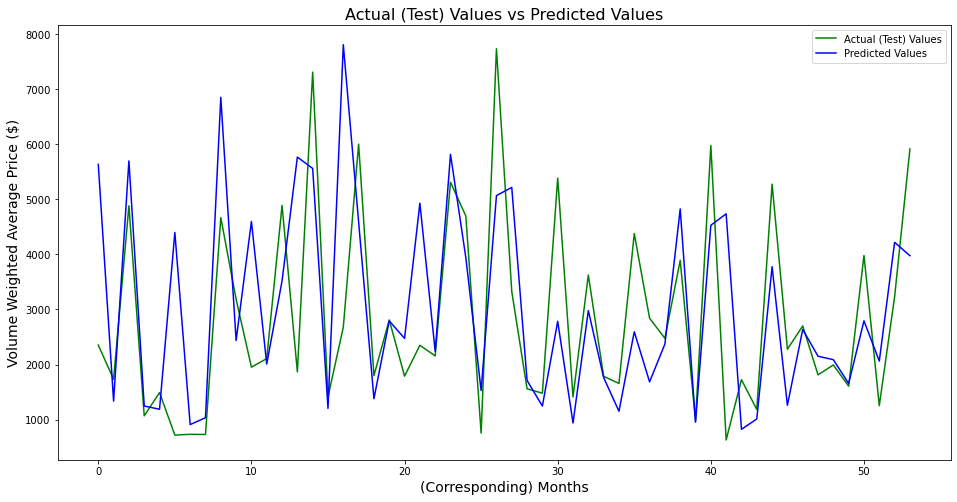

In [14]:
# making predictions using the training dataset to evaluate the training performance of the model
test_predictions = model.predict(X_test)

# creating a figure for the comparison of actual and predicted values
plt.figure(figsize = (16, 8))

# plotting actual training values and predicted values
plt.plot(y_test, color = 'green', label = 'Actual (Test) Values')
plt.plot(test_predictions, color = 'blue', label = 'Predicted Values')

# labeling and naming the figure
plt.xlabel('(Corresponding) Months', fontsize = 14)
plt.ylabel('Volume Weighted Average Price ($)', fontsize = 14)
plt.title('Actual (Test) Values vs Predicted Values', fontsize = 16)

# putting a legend into the figure
plt.legend()

In [15]:
# converting the setting the 'Data' column to the 'datetime' format 
data_Murray_Goulburn_Murray["Date"] = pd.to_datetime(data_Murray_Goulburn_Murray["Date"], format = '%Y/%m/%d')

In [16]:
# modifying the current datetime format of the 'Date' and formatting it separately as years and months
data_Murray_Goulburn_Murray["Year"] = data_Murray_Goulburn_Murray["Date"].dt.year
data_Murray_Goulburn_Murray["Month"] = data_Murray_Goulburn_Murray["Date"].dt.month

# extracting processed transaction data only for months of June (6), July (7), and August (8)
data_Murray_Goulburn_Murray_season_3 = data_Murray_Goulburn_Murray[data_Murray_Goulburn_Murray["Month"].between(6, 8)]

# removing the previous date information from the new dataset after creating a new date feature
data_Murray_Goulburn_Murray_season_3 = data_Murray_Goulburn_Murray_season_3.drop(['Year'], axis = 1)
data_Murray_Goulburn_Murray_season_3 = data_Murray_Goulburn_Murray_season_3.drop(['Month'], axis = 1)

# setting the date feature of the dataset as an index
data_Murray_Goulburn_Murray_season_3.set_index('Date', inplace = True)

In [17]:
# displaying the modified data to clearly see the changes made
data_Murray_Goulburn_Murray_season_3.head()

,Total Traded Volume (ML),Volume Weighted Average Price ($)
Date,,
2009-06-01,2806.6,672.739543
2009-07-01,18812.9,2227.445579
2009-08-01,1290.2,2265.075947
2010-06-01,5793.9,2201.404923
2010-07-01,6024.5,2072.838543


In [18]:
# extracting the column of 'Volume Weighted Average Price ($)' from the data
seasonal_price_data = data_Murray_Goulburn_Murray_season_3['Volume Weighted Average Price ($)']

# choosing a window size and creating appropriate datasets for time series estimation

window_size = 3

X_new, y_new = data_to_X_y(seasonal_price_data, window_size)

# displaying shapes of reformed datasets
X_new.shape, y_new.shape

((42, 3, 1), (42,))

In [19]:
# generating training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.3, shuffle = True)

# displaying shapes of training and test datasets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((29, 3, 1), (29,), (13, 3, 1), (13,))

In [20]:
# training the model and recording its training history for further performance analysis
model_new_training = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose = 0)

In [21]:
# making predictions using the training dataset to evaluate the training performance of the model
train_new_predictions = model.predict(X_train)

# making predictions using the training dataset to evaluate the training performance of the model
test_new_predictions = model.predict(X_test)

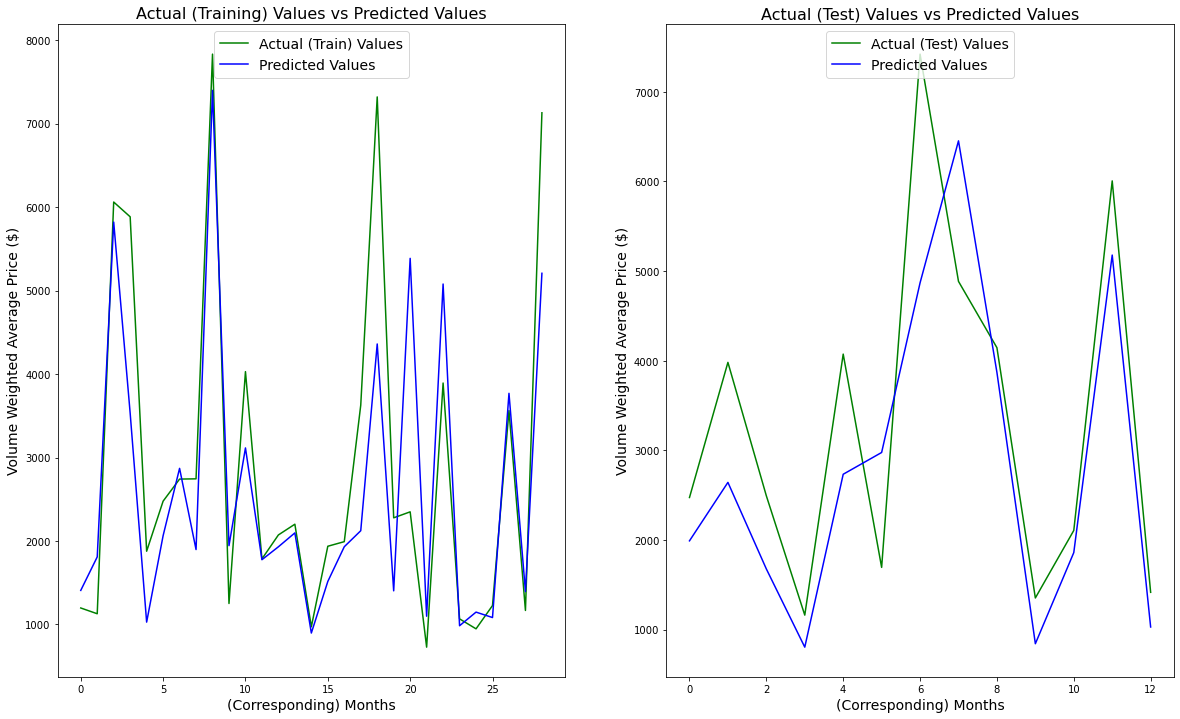

In [26]:
# creating a figure 
plt.figure(figsize = (20, 12))

plt.subplot(1, 2, 1)

# plotting actual training values and predicted values
plt.plot(y_train, color = 'green', label = 'Actual (Train) Values')
plt.plot(train_new_predictions, color = 'blue', label = 'Predicted Values')

# labeling and naming the first sub-plot
plt.xlabel('(Corresponding) Months', fontsize = 14)
plt.ylabel('Volume Weighted Average Price ($)', fontsize = 14)
plt.title('Actual (Training) Values vs Predicted Values', fontsize = 16)

# putting a legend into the figure
plt.legend(loc = 'upper center', fontsize = 14)


plt.subplot(1, 2, 2)

# plotting actual test values and predicted values
plt.plot(y_test, color = 'green', label = 'Actual (Test) Values')
plt.plot(test_new_predictions, color = 'blue', label = 'Predicted Values')

# labeling and naming the second sub-plot
plt.xlabel('(Corresponding) Months', fontsize = 14)
plt.ylabel('Volume Weighted Average Price ($)', fontsize = 14)
plt.title('Actual (Test) Values vs Predicted Values', fontsize = 16)

# putting a legend into the figure
plt.legend(loc = 'upper center', fontsize = 14)

plt.savefig("Time Series Prediction via an LSTM model .png", dpi = 300)